# Adversarial Search: Playing Connect 4

Student Name: Jonathan

I have used the following AI tools: ChatGPT and Google Gemini

I understand that my submission needs to be my own work: JM

## Instructions

Total Points: Undergraduates 100, graduate students 110

Complete this notebook and submit it. The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed. Submit the completely rendered notebook as a HTML file.


## Introduction

You will implement different versions of agents that play Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

Note that [Connect-4 has been solved](https://en.wikipedia.org/wiki/Connect_Four#Mathematical_solution)
in 1988. A connect-4 solver with a discussion of how to solve different parts of the problem can be found here: https://connect4.gamesolver.org/en/

## Task 1: Defining the Search Problem [10 point]

Define the components of the search problem:

* Initial state
* Actions
* Transition model (result function)
* Goal state (terminal state and utility)

Describe each component and then implement it as a function that can be used by search algorithms.

In [ ]:
# Your code/answer goes here.

How big is the state space? Give an estimate and explain it.

In [ ]:
# Your answer goes here.

How big is the game tree that minimax search will go through? Give an estimate and explain it.

In [ ]:
# Your answer goes here.

## Task 2: Game Environment and Random Agent [25 point]

Use a numpy character array as the board.

In [1]:
import numpy as np

def empty_board(shape=(6, 7)):
    return np.full(shape=shape, fill_value=0)

print(empty_board())

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


The standard board is $6 \times 7$ but you can use smaller boards to test your code. Instead of colors (red and yellow), I use 1 and -1 to represent the players. Make sure that your agent functions all have the from: `agent_type(board, player = 1)`, where board is the current board position (in the format above) and player is the player whose next move it is and who the agent should play (as 1 and -1).

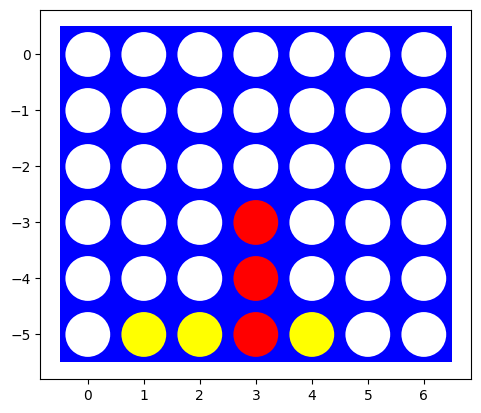

In [2]:
# Visualization code by Randolph Rankin

import matplotlib.pyplot as plt

def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()

board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]]
visualize(board)

Implement helper functions for:

* A check for available actions in each state `actions(state)`.
* The transition model `result(state, player, action)`.
* Check for terminal states `terminal(state)`.
* The utility function `utility(state, player)`.

The player argument is used so your agent can play red or yellow.
Make sure that all these functions work with boards of different sizes (number of columns and rows).
You can follow the [tic-tac-toe example from class.](https://colab.research.google.com/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_definitions.ipynb)

In [3]:
# Your code/ answer goes here.
# Your code/ answer goes here.
# Your code/ answer goes here.

def actions(state):
  rows, cols = np.where(np.array(state)==0)
  available_spaces = [(int(row), int(col)) for row, col in zip(rows, cols)]
  available_moves = []

  #highest row for each column
  moves = {}
  for i in range(len(state[0])):
    moves[i] = 0
  for i in range (len(available_spaces)):
    if available_spaces[i][0] == 0 and moves[available_spaces[i][1]] == 0:
      #del moves[available_spaces[i][1]]
      continue
    moves[available_spaces[i][1]] = max(available_spaces[i][0], moves[available_spaces[i][1]])
  return moves

def result(state, player, action):
  if state[action[0]][action[1]] != 0:
    raise ValueError("Invalid action")
  state = state.copy()
  state[action[0]][action[1]] = player
  return state

def utility(state, player = -1):
  goal = check_board(state)
  if goal == 'd':
    return 0
  if goal == player:
    return 1
  if goal == other(player):
    return -1
  return None

def terminal(state):
    return check_board(state)!='n'

def check_board(state):
    """check the board and return one of x, o, d (draw), or n (for next move)"""

    state = np.array(state).reshape((len(state), len(state.T)))

    def check_four(line):
        """Helper to check for 4 consecutive non-zero same values."""
        for i in range(len(line) - 3):
            if line[i] != 0 and line[i] == line[i+1] == line[i+2] == line[i+3]:
                return line[i]
        return None

    # Check horizontal
    for row in state:
        winner = check_four(row)
        if winner:
            return winner

    # Check vertical
    for col in state.T:
        winner = check_four(col)
        if winner:
            return winner

    # Check diagonals (bottom-left to top-right)
    for i in range(-2, 4):  # diagonals that are at least length 4
        diag = np.diagonal(state, offset=i)
        winner = check_four(diag)
        if winner:
            return winner

    # Check diagonals (top-left to bottom-right)
    flipped = np.fliplr(state)
    for i in range(-2, 4):
        diag = np.diagonal(flipped, offset=i)
        winner = check_four(diag)
        if winner:
            return winner

    # Check for draw
    if np.all(state != 0):
        return 'd'

    return 'n'

def other(player):
    if player == -1: return 1
    else: return -1


Implement an agent that plays randomly. Make sure the agent function receives as the percept the board and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(board, player = 1): ...`

The argument `player` is used for agents that do not store what color they are playing. The value passed on by the environment should be 1 ot -1 for player red and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

In [4]:
# Your code/ answer goes here.
# Your code/ answer goes here.
import random
def random_player(board, player = None):
  key = random.choice(list(actions(board)))
  while board[actions(board)[key]][key] != 0:
    key = random.choice(list(actions(board)))
  return (actions(board)[key],key)

Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

In [5]:
# Your code/ answer goes here.
# Your code/ answer goes here.
def play(player1=1,player2=-1,N=100,show_final_board = False):
  results = {-1:0,1:0,'d':0}
  for i in range(N):
    board = empty_board()
    while True:
      a = random_player(board,-1)
      board = result(board,-1,a)
      win = check_board(board)
      if win!='n':
        results[win]+=1
        break
      b = random_player(board,1)
      board = result(board,1,b)
      win = check_board(board)
      if win!='n':
        results[win]+=1
        break
    if show_final_board:
     visualize(board)
  return results

print(play())

{-1: 57, 1: 43, 'd': 0}


## Task 3: Minimax Search with Alpha-Beta Pruning

### Implement the Search [20 points]

Implement minimax search starting from a given board for specifying the player.

__Important Notes:__
* You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).
* Make sure that all your agent functions have a signature consistent with the random agent above and that it [uses a class to store state information.](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/HOWTOs/store_agent_state_information.ipynb)
This is essential to be able play against agents from other students later.
* The game tree for a $6 \times 7$ board is huge and optimal algorithms need to visit each or a large percentage of all nodes in the tree. You can experiment with smaller boards like a $4 \times 4$ board first.

In [6]:

import numpy as np

class Game:
    def __init__(self):
        pass

    def actions(self, state):
        rows, cols = np.where(np.array(state) == 0)
        available_spaces = [(int(row), int(col)) for row, col in zip(rows, cols)]
        available_moves = []

        moves = {}
        for i in range(len(state[0])):
            moves[i] = 0
        for i in range(len(available_spaces)):
            if available_spaces[i][0] == 0 and moves[available_spaces[i][1]] == 0:
                continue
            moves[available_spaces[i][1]] = max(available_spaces[i][0], moves[available_spaces[i][1]])

        # Convert moves dict into list of (row, col) actions
        available_moves = [(row, col) for col, row in moves.items() if row != 0 or (row == 0 and np.array(state)[row, col] == 0)]
        return available_moves

    def result(self, state, player, action):
        if state[action[0]][action[1]] != 0:
            raise ValueError("Invalid action")
        new_state = np.copy(state)
        new_state[action[0]][action[1]] = player
        return new_state

    def utility(self, state, player=-1):
        goal = check_board(state)
        if goal == 'd':
            return 0
        if goal == player:
            return 1
        if goal == other(player):
            return -1
        return None

    def is_terminal(self, state):
        return check_board(state) != 'n'

    def to_move(self, state):
        """Assumes -1 starts. Counts pieces to determine next player."""
        flat = np.array(state).flatten()
        x_count = np.sum(flat == -1)
        o_count = np.sum(flat == 1)
        return -1 if x_count <= o_count else 1

def check_board(state):
    """check the board and return one of x, o, d (draw), or n (for next move)"""

    state = np.array(state).reshape((len(state), len(state.T)))

    def check_four(line):
        for i in range(len(line) - 3):
            if line[i] != 0 and line[i] == line[i+1] == line[i+2] == line[i+3]:
                return line[i]
        return None

    # Check horizontal
    for row in state:
        winner = check_four(row)
        if winner:
            return winner

    # Check vertical
    for col in state.T:
        winner = check_four(col)
        if winner:
            return winner

    # Check diagonals (bottom-left to top-right)
    for i in range(-2, 4):
        diag = np.diagonal(state, offset=i)
        winner = check_four(diag)
        if winner:
            return winner

    # Check diagonals (top-left to bottom-right)
    flipped = np.fliplr(state)
    for i in range(-2, 4):
        diag = np.diagonal(flipped, offset=i)
        winner = check_four(diag)
        if winner:
            return winner

    # Check for draw
    if np.all(state != 0):
        return 'd'

    return 'n'

def other(player):
    return 1 if player == -1 else -1

# Alpha-Beta Functions

def alpha_beta_search(game, state):
    player = game.to_move(state)
    value, move = max_value(game, state, -np.inf, np.inf, player)
    return move

def max_value(game, state, alpha, beta, player):
    if game.is_terminal(state):
        return game.utility(state, player), None
    v = -np.inf
    move = None
    for a in game.actions(state):
        v2, _ = min_value(game, game.result(state, player, a), alpha, beta, player)
        if v2 > v:
            v, move = v2, a
            alpha = max(alpha, v)
        if v >= beta:
            return v, move
    return v, move

def min_value(game, state, alpha, beta, player):
    if game.is_terminal(state):
        return game.utility(state, player), None
    v = np.inf
    move = None
    for a in game.actions(state):
        v2, _ = max_value(game, game.result(state, other(player), a), alpha, beta, player)
        if v2 < v:
            v, move = v2, a
            beta = min(beta, v)
        if v <= alpha:
            return v, move
    return v, move


Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

Board 1:


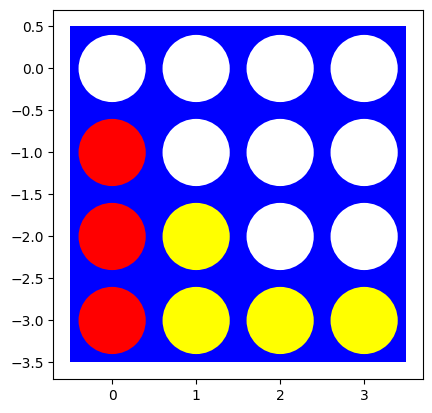

Agent selected move: (0, 0)

Time taken for agent to select next move: 0.0117 seconds


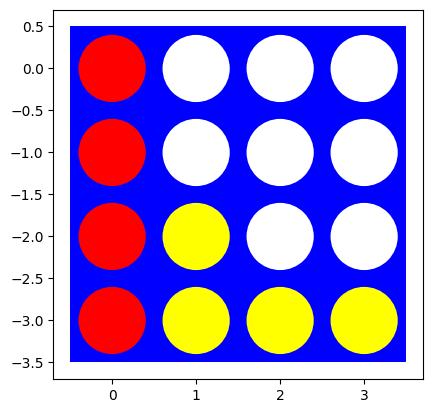

Board 2:


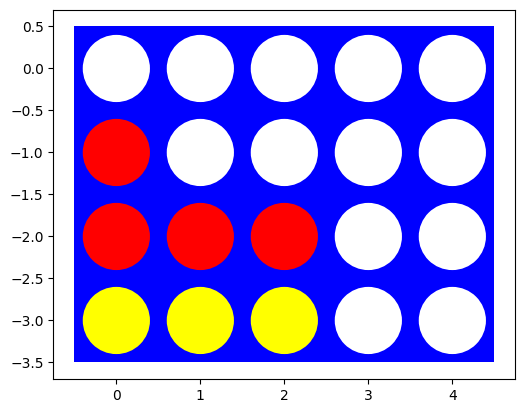

Agent selected move: (3, 3)

Time taken for agent to select next move: 0.4364 seconds


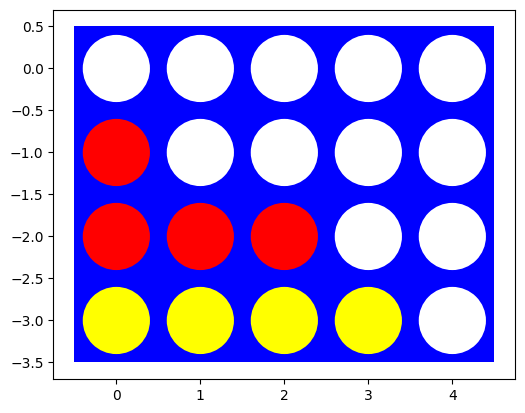

Board 3:


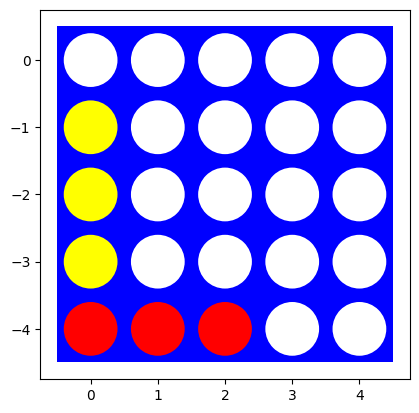

Agent selected move: (0, 0)

Time taken for agent to select next move: 0.6581 seconds


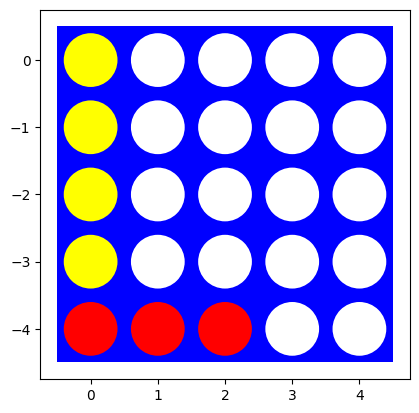

Board 4:


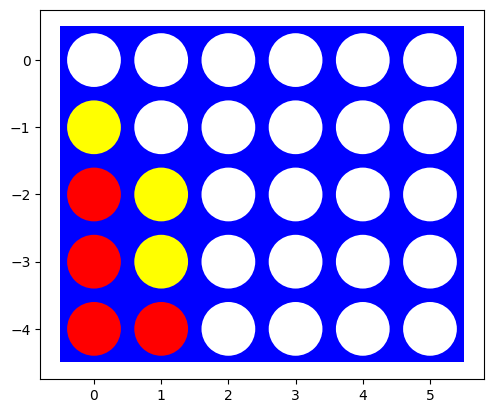

Agent selected move: (0, 0)

Time taken for agent to select next move: 229.5901 seconds


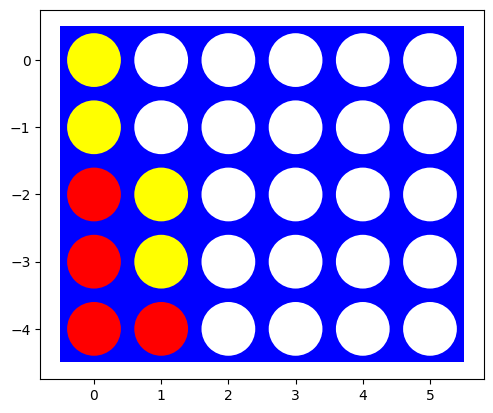

Board 5:


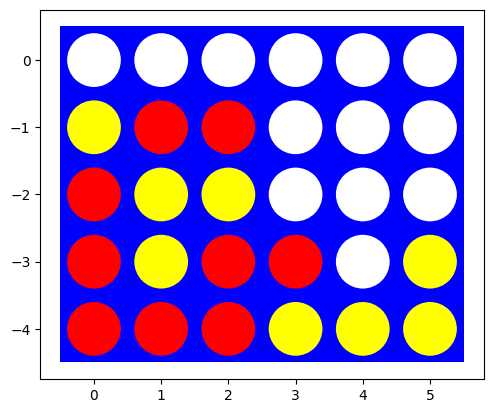

Agent selected move: (2, 3)

Time taken for agent to select next move: 1.5934 seconds


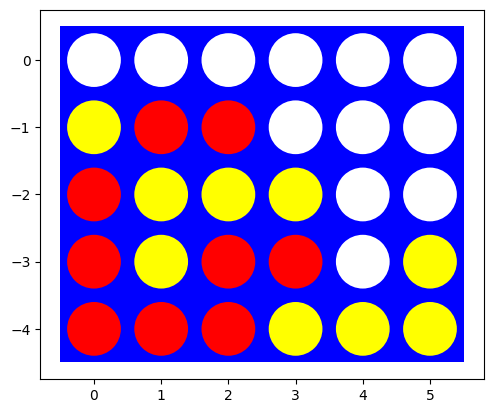

In [7]:
# Your code/ answer goes here.
import time
import numpy as np

# Initialize game
game = Game()

# Test Boards
boards = []

board1 = np.array([
    [0, 0, 0, 0],
    [1, 0, 0, 0],
    [1, -1, 0, 0],
    [1, -1, -1, -1]
])

board2 = np.array([
    [0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0],
    [1, 1, 1, 0, 0],
    [-1, -1, -1, 0, 0]
])

board3 = np.array([
    [0, 0, 0, 0, 0],
    [-1, 0, 0, 0, 0],
    [-1, 0, 0, 0, 0],
    [-1, 0, 0, 0, 0],
    [1, 1, 1, 0, 0]
])

board4 = np.array([
    [0, 0, 0, 0, 0, 0],
    [-1, 0, 0, 0, 0, 0],
    [1, -1, 0, 0, 0, 0],
    [1, -1, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0]
])

board5 = np.array([
    [0, 0, 0, 0, 0, 0],
    [-1, 1, 1, 0, 0, 0],
    [1, -1, -1, 0, 0, 0],
    [1, -1, 1, 1, 0, -1],
    [1, 1, 1, -1, -1, -1]
])

boards = [board1, board2, board3, board4, board5]

# Test Loop
for i, board in enumerate(boards, 1):
    print(f"Board {i}:")
    visualize(board)
    start = time.time()
    move = alpha_beta_search(game, board)
    end = time.time()
    print(f"Agent selected move: {move}\n")
    print(f"Time taken for agent to select next move: {end - start:.4f} seconds")
    player = game.to_move(board)
    if move is not None:
      board = result(board,player,move)
      visualize(board)


How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns/rows. Explain why using this algorithm on a standard $6 \times 7$ board is not feasible.

In [ ]:
# Your code/ answer goes here.


### Move ordering [5 points]

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move?

In [8]:
# Your code/ answer goes here.
def order_moves(state, moves):
    center = len(state[0]) // 2
    return sorted(moves, key=lambda move: abs(move[1] - center))

def max_value(game, state, alpha, beta, player):
    if game.is_terminal(state):
        return game.utility(state, player), None
    v = -np.inf
    move = None
    for a in order_moves(state, game.actions(state)):
        v2, _ = min_value(game, game.result(state, player, a), alpha, beta, player)
        if v2 > v:
            v, move = v2, a
            alpha = max(alpha, v)
        if v >= beta:
            return v, move
    return v, move

def min_value(game, state, alpha, beta, player):
    if game.is_terminal(state):
        return game.utility(state, player), None
    v = np.inf
    move = None
    for a in order_moves(state, game.actions(state)):
        v2, _ = max_value(game, game.result(state, other(player), a), alpha, beta, player)
        if v2 < v:
            v, move = v2, a
            beta = min(beta, v)
        if v <= alpha:
            return v, move
    return v, move


Board 1:


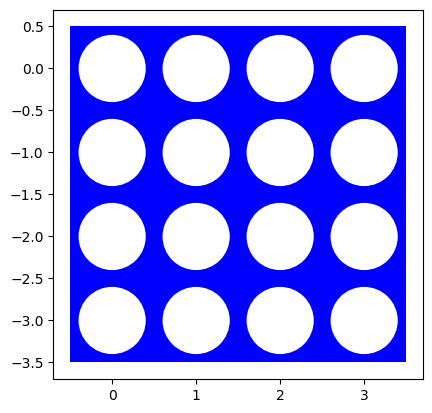

Agent selected move: (3, 2)

Time taken for agent to select next move: 10.7359 seconds


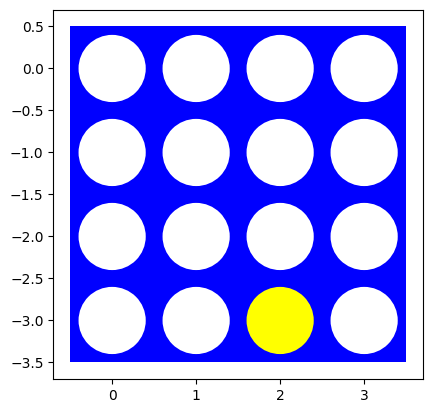

In [11]:
game = Game()

# Test Boards
boards = []

board1 = np.array([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0]
])

boards = [board1]
for i, board in enumerate(boards, 1):
    print(f"Board {i}:")
    visualize(board)
    start = time.time()
    move = alpha_beta_search(game, board)
    end = time.time()
    print(f"Agent selected move: {move}\n")
    print(f"Time taken for agent to select next move: {end - start:.4f} seconds")
    player = game.to_move(board)
    if move is not None:
      board = result(board,player,move)
      visualize(board)

### The first few moves [5 points]

Start with an empty board. This is the worst case scenario for minimax search since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do?

In [ ]:
# Your code/ answer goes here.

### Playtime [5 points]

Let the Minimax Search agent play a random agent on a $4 \times 4$ board. Analyze wins, losses and draws.

In [ ]:
# Your code/ answer goes here.

## Task 4: Heuristic Alpha-Beta Tree Search

### Heuristic evaluation function [15 points]

Define and implement a heuristic evaluation function. Make sure that the heuristic value stays in the correct range.

In [59]:
# Your code/ answer goes here.
def alpha_beta_search(game, state, depth=4):
    player = game.to_move(state)
    value, move = max_value(game, state, -np.inf, np.inf, player, depth)
    return move


def max_value(game, state, alpha, beta, player, depth):
    if game.is_terminal(state) or depth == 0:
        return game.utility(state, player), None
    v = -np.inf
    move = None
    for a in game.actions(state):
        v2, _ = min_value(game, game.result(state, player, a), alpha, beta, player, depth-1)
        if v2 > v:
            v, move = v2, a
            alpha = max(alpha, v)
        if v >= beta:
            return v, move
    return v, move

def min_value(game, state, alpha, beta, player, depth):
    if game.is_terminal(state) or depth == 0:
        return game.utility(state, player), None
    v = np.inf
    move = None
    for a in game.actions(state):
        v2, _ = max_value(game, game.result(state, other(player), a), alpha, beta, player, depth-1)
        if v2 < v:
            v, move = v2, a
            beta = min(beta, v)
        if v <= alpha:
            return v, move
    return v, move





### Cutting Off Search [10 points]

Modify your minimax search with alpha-beta pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

Board 1:


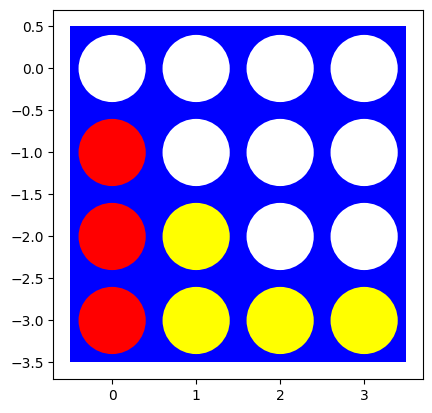

TypeError: '<' not supported between instances of 'NoneType' and 'float'

In [60]:
# Your code/ answer goes here.

# Your code/ answer goes here.
import time
import numpy as np

# Initialize game
game = Game()

# Test Boards
boards = []

board1 = np.array([
    [0, 0, 0, 0],
    [1, 0, 0, 0],
    [1, -1, 0, 0],
    [1, -1, -1, -1]
])

board2 = np.array([
    [0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0],
    [1, 1, 1, 0, 0],
    [-1, -1, -1, 0, 0]
])

board3 = np.array([
    [0, 0, 0, 0, 0],
    [-1, 0, 0, 0, 0],
    [-1, 0, 0, 0, 0],
    [-1, 0, 0, 0, 0],
    [1, 1, 1, 0, 0]
])

board4 = np.array([
    [0, 0, 0, 0, 0, 0],
    [-1, 0, 0, 0, 0, 0],
    [1, -1, 0, 0, 0, 0],
    [1, -1, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0]
])

board5 = np.array([
    [0, 0, 0, 0, 0, 0],
    [-1, 1, 1, 0, 0, 0],
    [1, -1, -1, 0, 0, 0],
    [1, -1, 1, 1, 0, -1],
    [1, 1, 1, -1, -1, -1]
])

boards = [board1, board2, board3, board4, board5]

# Test Loop
for i, board in enumerate(boards, 1):
    print(f"Board {i}:")
    visualize(board)
    start = time.time()
    move = alpha_beta_search(game, board)
    end = time.time()
    print(f"Agent selected move: {move}\n")
    print(f"Time taken for agent to select next move: {end - start:.4f} seconds")
    if move is not None:
      board = result(board,player,move)
      visualize(board)

Experiment with the same manually created boards as above to check if the agent spots wining opportunities.

In [ ]:
# Your code/ answer goes here.

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [ ]:
# Your code/ answer goes here.

### Playtime [5 points]

Let two heuristic search agents (different cutoff depth) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

In [ ]:
# Your code/ answer goes here.